In [ ]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf
import cv2

TensorFlow 1.x selected.


In [ ]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()
  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')
  im = Image.fromarray(seg_image)
  #im.save("seg_map.png", format = 'PNG',  quality = 100)

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()



In [ ]:
def image_to_full_map(original_im):

  resized_im, label_map = MODEL.run(original_im)
  #adding colors to original map
  seg_image = label_to_color_image(label_map).astype(np.uint8)
  #loading colored map and resizing
  h,w = original_im.size
  data = Image.fromarray(seg_image) 
  resized_img = data.resize((h, w), Image.NEAREST)
  
  resized_img.save("colored_resized_map.png", format = 'PNG',  quality = 100)

  #256 rows of length 3
  colormap = np.zeros((256, 3), dtype=int)
  #ind is array going from 0 to 244
  ind = np.arange(256, dtype=int)

  #set up pallette. allows us to go color -> label
  for shift in reversed(range(8)):
      for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
      ind >>= 3
  
  #getting dimensions we need
  colored_map_array = np.array(resized_img)
  label_h, label_w, _ = colored_map_array.shape
  resized_label = np.zeros((label_h, label_w), dtype= 'uint8')

  #create pallete list
  pallete = []
  for color in colormap:
    pallete.append(list(color))

  #create list of all colors in image
  color_list = []
  #for each row
  for i in range(label_h):
    #for each column
    for j in range(label_w):
      color_list.append(list(colored_map_array[i][j]))

  label_vals= []
  for color in color_list:
    val = pallete.index(color)
    label_vals.append(val)
  
  label_vals = np.array(label_vals)
  label_map = np.reshape(label_vals,(label_h, label_w))

  return label_map

In [ ]:
MODEL_NAME = "ADE20k" #@param ["Pascal VOC 2012 (foreground segmentation)", "ADE20k"]

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'Pascal VOC 2012 (foreground segmentation)':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    'ADE20k':
        'deeplabv3_xception_ade20k_train_2018_05_29.tar.gz'
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')
if MODEL_NAME == "Pascal VOC 2012 (foreground segmentation)":
  LABEL_NAMES = np.asarray([
      'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
      'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
      'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'])
elif MODEL_NAME == "ADE20k":
  LABEL_NAMES = np.asarray(['Name','wall', 'building;edifice', 'sky', 'floor;flooring', 'tree', 'ceiling', 'road;route', 'bed', 'windowpane;window', 'grass', 'cabinet', 'sidewalk;pavement', 'person;individual;someone;somebody;mortal;soul', 'earth;ground', 'door;double;door', 'table', 'mountain;mount', 'plant;flora;plant;life', 'curtain;drape;drapery;mantle;pall', 'chair', 'car;auto;automobile;machine;motorcar', 'water', 'painting;picture', 'sofa;couch;lounge', 'shelf', 'house', 'sea', 'mirror', 'rug;carpet;carpeting', 'field', 'armchair', 'seat', 'fence;fencing', 'desk', 'rock;stone', 'wardrobe;closet;press', 'lamp', 'bathtub;bathing;tub;bath;tub', 'railing;rail', 'cushion', 'base;pedestal;stand', 'box', 'column;pillar', 'signboard;sign', 'chest;of;drawers;chest;bureau;dresser', 'counter', 'sand', 'sink', 'skyscraper', 'fireplace;hearth;open;fireplace', 'refrigerator;icebox', 'grandstand;covered;stand', 'path', 'stairs;steps', 'runway', 'case;display;case;showcase;vitrine', 'pool;table;billiard;table;snooker;table', 'pillow', 'screen;door;screen', 'stairway;staircase', 'river', 'bridge;span', 'bookcase', 'blind;screen', 'coffee;table;cocktail;table', 'toilet;can;commode;crapper;pot;potty;stool;throne', 'flower', 'book', 'hill', 'bench', 'countertop', 'stove;kitchen;stove;range;kitchen;range;cooking;stove', 'palm;palm;tree', 'kitchen;island', 'computer;computing;machine;computing;device;data;processor;electronic;computer;information;processing;system', 'swivel;chair', 'boat', 'bar', 'arcade;machine', 'hovel;hut;hutch;shack;shanty', 'bus;autobus;coach;charabanc;double-decker;jitney;motorbus;motorcoach;omnibus;passenger;vehicle', 'towel', 'light;light;source', 'truck;motortruck', 'tower', 'chandelier;pendant;pendent', 'awning;sunshade;sunblind', 'streetlight;street;lamp', 'booth;cubicle;stall;kiosk', 'television;television;receiver;television;set;tv;tv;set;idiot;box;boob;tube;telly;goggle;box', 'airplane;aeroplane;plane', 'dirt;track', 'apparel;wearing;apparel;dress;clothes', 'pole', 'land;ground;soil', 'bannister;banister;balustrade;balusters;handrail', 'escalator;moving;staircase;moving;stairway', 'ottoman;pouf;pouffe;puff;hassock', 'bottle', 'buffet;counter;sideboard', 'poster;posting;placard;notice;bill;card', 'stage', 'van', 'ship', 'fountain', 'conveyer;belt;conveyor;belt;conveyer;conveyor;transporter', 'canopy', 'washer;automatic;washer;washing;machine', 'plaything;toy', 'swimming;pool;swimming;bath;natatorium', 'stool', 'barrel;cask', 'basket;handbasket', 'waterfall;falls', 'tent;collapsible;shelter', 'bag', 'minibike;motorbike', 'cradle', 'oven', 'ball', 'food;solid;food', 'step;stair', 'tank;storage;tank', 'trade;name;brand;name;brand;marque', 'microwave;microwave;oven', 'pot;flowerpot', 'animal;animate;being;beast;brute;creature;fauna', 'bicycle;bike;wheel;cycle', 'lake', 'dishwasher;dish;washer;dishwashing;machine', 'screen;silver;screen;projection;screen', 'blanket;cover', 'sculpture', 'hood;exhaust;hood', 'sconce', 'vase', 'traffic;light;traffic;signal;stoplight', 'tray', 'ashcan;trash;can;garbage;can;wastebin;ash;bin;ash-bin;ashbin;dustbin;trash;barrel;trash;bin', 'fan', 'pier;wharf;wharfage;dock', 'crt;screen', 'plate', 'monitor;monitoring;device', 'bulletin;board;notice;board', 'shower', 'radiator', 'glass;drinking;glass', 'clock', 'flag'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


running deeplab on image https://akm-img-a-in.tosshub.com/indiatoday/images/story/202012/photo-1560759995-d237fb70a79d_1200x768.jpeg?xufGaycR7Hac57j3iZGj1BrvLvaeK_J3&size=770:433...


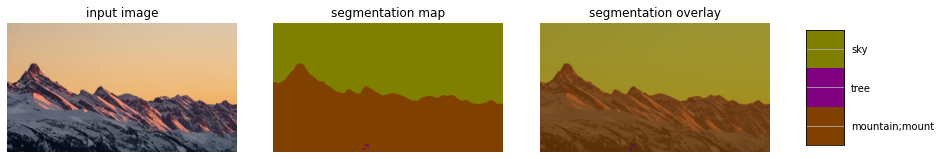

In [ ]:
IMAGE_URL = 'https://akm-img-a-in.tosshub.com/indiatoday/images/story/202012/photo-1560759995-d237fb70a79d_1200x768.jpeg?xufGaycR7Hac57j3iZGj1BrvLvaeK_J3&size=770:433'  #@param {type:"string"}

def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

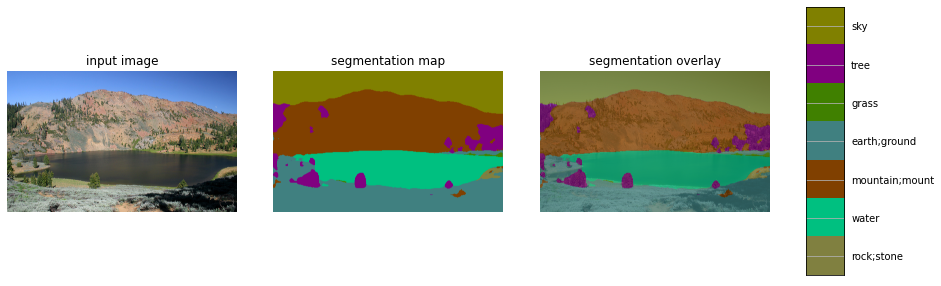

In [ ]:
IMAGE_URL = "https://hikemtshasta.files.wordpress.com/2013/09/trinity-alps-east-boulder-lake-june2007-051-copy-custom.jpg" #@param {type:"string"}
UploadedImage = False #@param {type:"boolean"}
Path_to_image = "/content/beach.jpg" #@param {type:"string"}

if UploadedImage == False:
  #load image using provided IMAGE_URL
  f = urllib.request.urlopen(IMAGE_URL)  
  jpeg_str = f.read()
  original_im = Image.open(BytesIO(jpeg_str))
else:
  original_im = Image.open(Path_to_image)
  

resized_map = image_to_full_map(original_im)
cv2.imwrite("resized_labelmap.png", resized_map)
vis_segmentation(original_im, resized_map)